In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pandas as pd
import rdata

In [4]:
def create_maldi_image(spectra_list):
    # Get the dimensions of the image
    n = int(math.sqrt(len(spectra_list)))
    # Create an empty numpy array to store the maldi image
    maldi_image = np.zeros((n, n))
    
    # Loop over each pixel in the image and assign the corresponding spectra
    for row in range(n):
        for col in range(n):
            avg_value = np.sum(spectra_list[row * n + col]) / len(spectra_list[row * n + col])
            #maldi_image[row, col] = int(avg_value * 255)
            maldi_image[row, col] = np.round(avg_value * 255).astype(np.uint8)
            
    return maldi_image

In [5]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [80]:
def recursionStart(spectra):
    featurePairs = []
    maxima = []
    minima = []
    
    for i in range(1, len(spectra) - 1):
        if spectra[i] > spectra[i-1]:
            if spectra[i] >= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] > spectra[j]:
                        maxima.append([i, spectra[i]])
                        break
                    elif spectra[i] < spectra[j]:
                        break
        if spectra[i] < spectra[i-1]:
            if spectra[i] <= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] < spectra[j]:
                        minima.append([i, spectra[i]])
                        break
                    elif spectra[i] > spectra[j]:
                        break
    maxima.sort(key = lambda element: element[1], reverse = True)
    minima.sort(key = lambda element: element[1])
    
    if len(maxima) == 0:
        return -1
    globalMaxima = maxima.pop(0)
    featurePairs.append([globalMaxima[0], globalMaxima[1] - minima[0][1]])
    
    recursionStep(0, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    recursionStep(len(spectra) - 1, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    
    return featurePairs

def recursionStep(start, end, maxima, minima, featurePairs):
    factor = 1
    if end < start:
        factor = -1
    currentMaxima = []
    for i in range(len(maxima)):
        position = maxima[i][0]
        if start * factor < position * factor and position * factor < end * factor:
            currentMaxima.append(maxima[i])
    if len(currentMaxima) == 0:
        return
    localMaxima = currentMaxima.pop(0)
    recursionStep(start, localMaxima[0], currentMaxima.copy(), minima.copy(), featurePairs)
    currentMinima = []
    for i in range(len(minima)):
        position = minima[i][0]
        if localMaxima[0] * factor < position * factor and position * factor < end * factor:
            currentMinima.append(minima[i])
    localMinima = currentMinima.pop(0)
    featurePairs.append([localMaxima[0], localMaxima[1] - localMinima[1]])
    recursionStep(localMinima[0], localMaxima[0], currentMaxima.copy(), currentMinima.copy(), featurePairs)
    recursionStep(localMinima[0], end, currentMaxima.copy(), currentMinima.copy(), featurePairs)
    
def getPersistenceTransformation(data_X, listOfK):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
        
    spectrasForEachK = []
    
    for k in listOfK:
        transformationForSpectra = []
        for i in range(0, len(spectras)):
            transformation = [0] * len(data_X.iloc[i])
            featurePairs = spectras[i][0:round(k*len(spectras[i]))]
            for x, fx in featurePairs:
                transformation[x] = fx
            transformationForSpectra.append(transformation)
        spectrasForEachK.append(transformationForSpectra)
    return spectrasForEachK

def getPersistenceTransformation(data_X, number_of_peaks):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
        
    spectrasForEachK = []
    
    transformationForSpectra = []
    for i in range(0, len(spectras)):
        transformation = [0] * len(data_X.iloc[i])
        if len(spectras[i]) == 1:
            k = 0
        else:
            k = number_of_peaks
        featurePairs = spectras[i][0:k]
        for x, fx in featurePairs:
            transformation[x] = fx
        transformationForSpectra.append(transformation)
    return transformationForSpectra

In [15]:
def read_data(path):
    parsed = rdata.parser.parse_file(path)
    converted = rdata.conversion.convert(parsed)
    data = np.array(list(converted.values()))[0]
    return data

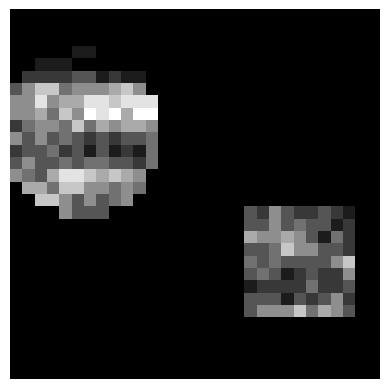

In [59]:
data = read_data("data/image_data.RData")
image = create_maldi_image(data)
plot_image(image)

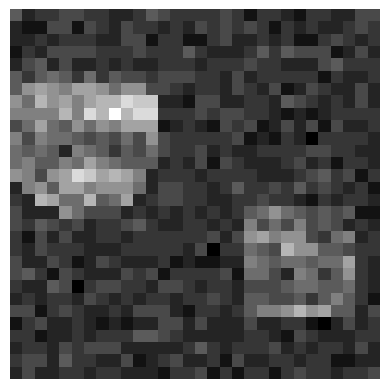

In [60]:
data_noisy = read_data("data/image_data_noise.RData")
image_noisy = create_maldi_image(data_noisy)
plot_image(image_noisy)
X = getPersistenceTransformation(data_X = pd.DataFrame(data_noisy), number_of_peaks = 50)
plot_image(create_maldi_image(X))

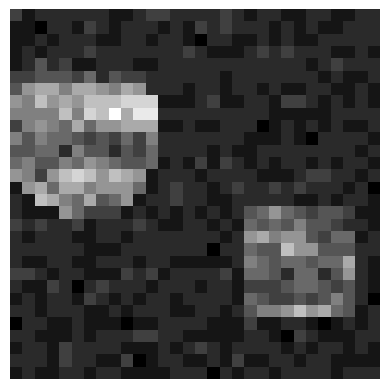

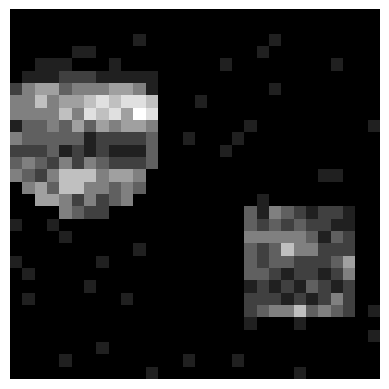

In [84]:
data_noisy2 = read_data("data/image_data_noise_02.RData")
image_noisy2 = create_maldi_image(data_noisy2)
plot_image(image_noisy2)
X = getPersistenceTransformation(data_X = pd.DataFrame(data_noisy2), number_of_peaks = 50)
plot_image(create_maldi_image(X))

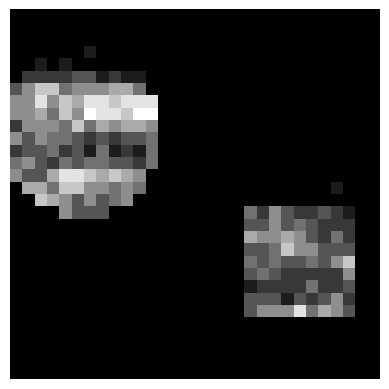

In [52]:
mean = 0
std_dev = 0.035
data_noisy = []
np.random.seed(123)
for i in range(len(data)):
    noise = np.random.normal(mean, std_dev, len(data[i]))
    data_noisy.append(data[i] + noise)
image_noisy = create_maldi_image(data_noisy)
plot_image(image_noisy)